## **GROUP 10**

**PHASE 2 CAPSTONE PROJECT**

**MEMBERS:**

Job Cheruyout

Eric Miriti

Susan Mworia

Lydia Mangoa

Evans Makau

Wambui Kariuki  

## **BUSINESS UNDERSTANDING**

### **Problem Statement**

Our company is launching a new movie studio, inspired by the success of original video content from leading companies. To guide this new venture, we are studying current box office trends to determine the most successful genres and themes. These insights will be turned into actionable recommendations to help the studio create films that will resonate with audiences and perform well in theaters.

### **Business Goals**
1. **Maximize Revenue Potential**: Study box office data on income to determine the most profitable types of films.
2. **Tailor Films to Audience Preferences**: Analyze data on runtime, genres, to identify the most popular formats and genres in the market. Use these insights to create films that align with audience expectations and preferences in terms of length and genre.
3. **Optimize Film Quality and Popularity**: Leverage data on average ratings and the number of votes to identify the types of films with high audience satisfaction and strong engagement. Use this information to guide the studio’s film selection, aiming for high-quality productions with strong appeal.


### Success Criteria

- **Box Office Success**: Each film should meet the set gross income target.
- **Genre and Runtime Fit**: Films should match popular genres and runtimes, with success measured by positive audience reception in these areas.
- **Strong Audience Engagement**: Films should have an average rating of at least 7/10 and attract a significant number of votes, indicating positive audience feedback.
- **Good Financial Return**: Each film should generate a return on investment (ROI) of at least 2x the production cost, showing profitability.


## **DATA UNDERSTANDING**

This section involves examining and exploring the dataset to gain insights into its structure, content, and relevance to the project objectives. Key areas of focus include:

- **Dataset Overview**: Assess the size, structure, and format of the dataset to understand its scope.
- **Key Variables**: Identify critical variables such as gross income, genres, runtime, average ratings, and the number of votes.
- **Data Completeness**: Check for missing values or incomplete records that could impact the analysis.
- **Data Consistency**: Ensure uniformity in variables like genres and runtime to maintain accuracy in analysis.
- **Initial Observations**: Perform basic exploratory analysis to identify trends, patterns, or anomalies in the data.


### **Key Questions**


1.   What genres have require the highest budget?
2.   What genres have the longest runtime?
3.   What genres raked in the highest revenue?
4.   What is the relationship between votes, popularity and revenue?
5.   Can we prove several statistical concepts based on our data?


### **Data Sources**
Data is from below 2 provided sources:

1. IMDB
2. The Movie DB

### **Data Description**
Two databases were used as below:

1. **IMDB**: An sql database from which we use two tables i.e.

    *   **Title Basics**: consisting of 6 columns and 146,144 rows
    *   **Title ratings**: consisting of 3 columns and 73856 rows

2. **The Movie DB**:Contains 10 columns and 26,517 rows.
Data scraping was done to get more fields for analysis

### Categories of Data Used for Analysis:
- **Quantitative Data**: 
  - `runtime_minutes`
  - `vote_count`
  - `revenue`
  - `popularity`

- **Qualitative Data**: 
  - `primary_title`
  - `genres`


### **Data Collection**

Data availed from below websites:

For TMDB, data scraping was done to get more fields for analysis


*   https://www.themoviedb.org/
*   https://www.imdb.com/

## **DATA PREPARATION**

This will be handled through:

*   Combining tables from different databases
*   Handling Duplicates: Ensuring there are no repeated records
*   Handling Missing Data:Fill in or remove incomplete data points, such as missing report status.

#### TMDB



In [15]:
# import libraries
import pandas as pd
import ast
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_1samp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
# SCRAPING THE TMDB WEBSITE FOR DATA USING API CALLS
file_path = 'tmdb.movies.csv.gz'
data = pd.read_csv(file_path)

# TMDB API Key
API_KEY = '1747bacc4f65a1c1db0f28b00f7ec810'
BASE_URL = 'https://api.themoviedb.org/3'

# Function to query TMDB API
def fetch_movie_details(movie_id):
    try:
        # Movie details endpoint
        movie_url = f"{BASE_URL}/movie/{movie_id}?api_key={API_KEY}"
        credits_url = f"{BASE_URL}/movie/{movie_id}/credits?api_key={API_KEY}"

        # Fetch movie details
        movie_response = requests.get(movie_url).json()
        credits_response = requests.get(credits_url).json()

        # Extract required data
        overview = movie_response.get('overview', 'No overview available')
        revenue = movie_response.get('revenue', 'N/A')
        cast = [member['name'] for member in credits_response.get('cast', [])[:5]]  # Top 5 cast members
        director = next(
            (crew['name'] for crew in credits_response.get('crew', []) if crew['job'] == 'Director'),
            'N/A'
        )

        return {
            'Overview': overview,
            'Revenue': revenue,
            'Top Cast': ', '.join(cast),
            'Director': director
        }
    except Exception as e:
        return {
            'Overview': 'Error',
            'Revenue': 'Error',
            'Top Cast': 'Error',
            'Director': 'Error',
            'Error': str(e)
        }

# Add new columns for enriched data
data['Overview'] = None
data['Revenue'] = None
data['Top Cast'] = None
data['Director'] = None

# Fetch data for each movie
for index, row in data.iterrows():
    movie_id = row['id']
    details = fetch_movie_details(movie_id)
    data.at[index, 'Overview'] = details['Overview']
    data.at[index, 'Revenue'] = details['Revenue']
    data.at[index, 'Top Cast'] = details['Top Cast']
    data.at[index, 'Director'] = details['Director']
    time.sleep(0.2)

# Save the enriched dataset
output_file = 'enriched_tmdb_movies.csv'
data.to_csv(output_file, index=False)

# Print a final message after scraping is done
print(f"All movies have been processed. Enriched data saved to {output_file}")

All movies have been processed. Enriched data saved to enriched_tmdb_movies.csv


In [184]:
# MAPPING THE MOVIES TO THEIR RESPECTIVE GENRES USING GENRE IDS
 # To evaluate genre_ids strings as Python lists

# Load the enriched dataset
file_path = 'enriched_tmdb_movies.csv'
data = pd.read_csv(file_path)

# Predefined TMDB Genre Mapping
genre_mapping = {
    28: "Action",
    12: "Adventure",
    16: "Animation",
    35: "Comedy",
    80: "Crime",
    99: "Documentary",
    18: "Drama",
    10751: "Family",
    14: "Fantasy",
    36: "History",
    27: "Horror",
    10402: "Music",
    9648: "Mystery",
    10749: "Romance",
    878: "Science Fiction",
    10770: "TV Movie",
    53: "Thriller",
    10752: "War",
    37: "Western"
}

# Function to map genre IDs to names
def map_genres(genre_ids_str):
    try:
        genre_ids = ast.literal_eval(genre_ids_str)  # Convert string to list
        return ', '.join([genre_mapping.get(genre_id, "Unknown") for genre_id in genre_ids])
    except Exception as e:
        return "Unknown"

# Apply the mapping to the genre_ids column
data['Genres'] = data['genre_ids'].apply(map_genres)

# Save the updated dataset
output_file = 'final_tmdb.xlsx'
data.to_excel(output_file, index=False)

print(f"Updated dataset with genres saved to {output_file}")


Updated dataset with genres saved to final_tmdb.xlsx


In [185]:
tmdb_data = pd.read_excel('final_tmdb.xlsx')

In [187]:
# Merge with the tmdb budget dataset on 'id'
budget_data = pd.read_csv('budget_data.csv')
tmdb_data = pd.merge(tmdb_data, budget_data, on='id', how='left')

In [188]:
tmdb_data.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,Overview,Revenue,Top Cast,Director,Genres,Budget
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Harry, Ron and Hermione walk away from their l...",954305868,"Daniel Radcliffe, Emma Watson, Rupert Grint, T...",David Yates,"Adventure, Fantasy, Family",250000000.0
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,As the son of a Viking leader on the cusp of m...,494879471,"Jay Baruchel, Gerard Butler, Craig Ferguson, A...",Dean DeBlois,"Fantasy, Adventure, Animation, Family",165000000.0
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,With the world now aware of his dual life as t...,623933331,"Robert Downey Jr., Gwyneth Paltrow, Don Cheadl...",Jon Favreau,"Adventure, Action, Science Fiction",200000000.0
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,"Led by Woody, Andy's toys live happily in his ...",394436586,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"Animation, Comedy, Family",30000000.0
4,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,"Led by Woody, Andy's toys live happily in his ...",394436586,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",John Lasseter,"Animation, Comedy, Family",30000000.0


In [190]:
tmdb_data.shape

(28605, 16)

#### IMDB

In [180]:
file = "im.db"
con =sqlite3.connect(file)

In [181]:
cur = con.cursor()

In [182]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
print(tables)

[('movie_basics',), ('directors',), ('known_for',), ('movie_akas',), ('movie_ratings',), ('persons',), ('principals',), ('writers',)]


In [183]:
df = pd.read_sql("SELECT * FROM movie_basics", con)
df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [ ]:
df2 = pd.read_sql("SELECT * FROM movie_akas", con)
df2.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [ ]:
df.shape

(146144, 6)

#### **MERGING TMDB AND IMDB DATA**

In [233]:
# Load the TMDb and IMDb data
imdb_data = df

# Normalize title columns by converting to lowercase and trimming whitespace
tmdb_data['title_normalized'] = tmdb_data['title'].str.lower().str.strip()
imdb_data['primary_title_normalized'] = imdb_data['primary_title'].str.lower().str.strip()

# Check for common titles
common_titles = set(tmdb_data['title_normalized']).intersection(set(imdb_data['primary_title_normalized']))

# Count the number of movies in both datasets
common_count = len(common_titles)
print(f"Number of common movies between TMDb and IMDb based on titles: {common_count}")

Number of common movies between TMDb and IMDb based on titles: 15369


In [234]:
tmdb_common = tmdb_data[tmdb_data['title_normalized'].isin(common_titles)].sort_values(by='title')
imdb_common = imdb_data[imdb_data['primary_title_normalized'].isin(common_titles)].sort_values(by='primary_title')

In [235]:
# Load the TMDb and IMDb data and remove duplicated
tmdb_data = tmdb_common
imdb_data = imdb_common
tmdb_data = tmdb_data.drop_duplicates(subset=['title_normalized'])
imdb_data = imdb_data.drop_duplicates(subset=['primary_title_normalized'])

# Normalizing title columns by converting to lowercase and trimming whitespace
tmdb_data['title_normalized'] = tmdb_data['title'].str.lower().str.strip()
imdb_data['primary_title_normalized'] = imdb_data['primary_title'].str.lower().str.strip()

# Inner join on normalized titles
merged_data = pd.merge(
    imdb_data[['primary_title', 'start_year', 'runtime_minutes', 'genres', 'primary_title_normalized']],
    tmdb_data[['title', 'vote_average', 'vote_count', 'Revenue', 'Top Cast', 'Director', 'Genres', 'title_normalized', 'Budget','popularity']],
    left_on='primary_title_normalized',
    right_on='title_normalized',
    how='inner'
)

# Desired columns in the result
merged_data = merged_data[[
    'primary_title', 'start_year', 'runtime_minutes', 'genres', 'vote_average',
    'vote_count', 'Top Cast', 'Director', 'popularity', 'Budget', 'Revenue'
]]

# Save the merged dataset to a file
merged_data.to_csv('merged_movies.csv', index=False)

print("Merged dataset saved successfully!")


<ipython-input-235-1831bf5d6eac>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_data['primary_title_normalized'] = imdb_data['primary_title'].str.lower().str.strip()


Merged dataset saved successfully!


### **DATA CLEANING**

In [18]:
merged_data = pd.read_csv('Data/merged_movies.csv')
merged_data.head()

,primary_title,start_year,runtime_minutes,genres,vote_average,vote_count,Top Cast,Director,popularity,Budget,Revenue
0,#ALLMYMOVIES,2015,NaN,Documentary,9.0,4,Shia LaBeouf,Luke Turner,0.840,0.0,0
1,#Captured,2017,81.0,Thriller,3.2,6,"Lizze Gordon, Cody Renee Cameron, Eve Marlowe,...",Joe Homokay,1.418,0.0,0
2,#FollowFriday,2016,90.0,Thriller,3.2,7,"Courtney Lakin, Joseph Poliquin, Ashley Bratch...",Micho Rutare,1.646,0.0,0
3,#Horror,2015,101.0,"Crime,Drama,Horror",3.3,102,"Chloë Sevigny, Timothy Hutton, Natasha Lyonne,...",Tara Subkoff,6.099,1500000.0,0
4,#Lucky Number,2015,80.0,Comedy,6.0,2,"Tom Pelphrey, Natalie Hall, Method Man, Malcol...",Brendan Gabriel Murphy,0.919,1000000.0,0


In [20]:
merged_data.duplicated().sum()

0

In [22]:
merged_data.isna().sum()

primary_title         0
start_year            0
runtime_minutes     633
genres               97
vote_average          0
vote_count            0
Top Cast           1125
Director            368
popularity            0
Budget               95
Revenue              95
dtype: int64

#### Fill non numerical missing values with N/A

In [24]:
merged_data[['Director', 'Top Cast', 'genres']] = merged_data[['Director', 'Top Cast', 'genres']].fillna("N/A")

In [26]:
merged_data.isna().sum()

primary_title        0
start_year           0
runtime_minutes    633
genres               0
vote_average         0
vote_count           0
Top Cast             0
Director             0
popularity           0
Budget              95
Revenue             95
dtype: int64

In [28]:
# Ensure columns for correlation are numeric
merged_data['Revenue'] = pd.to_numeric(merged_data['Revenue'], errors='coerce')
merged_data['popularity'] = pd.to_numeric(merged_data['popularity'], errors='coerce')
merged_data['vote_average'] = pd.to_numeric(merged_data['vote_average'], errors='coerce')

In [30]:
# Replace rows with 0 in the revenue and budget columns with null
merged_data['Revenue'] = merged_data['Revenue'].replace(0, np.nan)
merged_data['Budget'] = merged_data['Budget'].replace(0, np.nan)

In [32]:
merged_data.isna().sum()

primary_title          0
start_year             0
runtime_minutes      633
genres                 0
vote_average           0
vote_count             0
Top Cast               0
Director               0
popularity             0
Budget             11526
Revenue            12190
dtype: int64

#### Filling missing values in Revenue column based on popularity

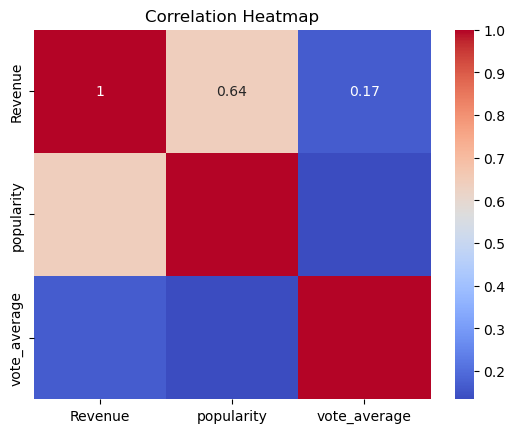

In [34]:
# Use correlation to establish the whether popularity can be used to predict revenue to fill missing values
numeric_features = merged_data[['Revenue', 'popularity', 'vote_average']]
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


As shown by the correlation matrix there is a strong positive correlation between a title's popularity and the revenue accrued (0.64). More popular movies may accrue higher revenues.

In [37]:
# Filling missing values in Revenue column based on popularity

# Ensure 'Revenue' and 'popularity' are numeric
merged_data['Revenue'] = pd.to_numeric(merged_data['Revenue'], errors='coerce')
merged_data['popularity'] = pd.to_numeric(merged_data['popularity'], errors='coerce')

# Filter non-missing data for training
non_missing = merged_data[merged_data['Revenue'].notna() & merged_data['popularity'].notna()]

# Prepare X and y for regression
X_train = non_missing[['popularity']].values  # Independent variable
y_train = non_missing['Revenue'].values  # Dependent variable

# Train-test split (optional, for model evaluation)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Train a linear regression model
regressor = LinearRegression()
regressor.fit(X_train_split, y_train_split)

# Predict missing Revenue values
missing = merged_data[merged_data['Revenue'].isna() & merged_data['popularity'].notna()]
X_missing = missing[['popularity']].values
predicted_revenue = regressor.predict(X_missing)

# Fill the missing Revenue values with predictions
merged_data.loc[merged_data['Revenue'].isna() & merged_data['popularity'].notna(), 'Revenue'] = predicted_revenue

merged_data.head()

,primary_title,start_year,runtime_minutes,genres,vote_average,vote_count,Top Cast,Director,popularity,Budget,Revenue
0,#ALLMYMOVIES,2015,NaN,Documentary,9.0,4,Shia LaBeouf,Luke Turner,0.840,NaN,-7.226549e+07
1,#Captured,2017,81.0,Thriller,3.2,6,"Lizze Gordon, Cody Renee Cameron, Eve Marlowe,...",Joe Homokay,1.418,NaN,-6.258784e+07
2,#FollowFriday,2016,90.0,Thriller,3.2,7,"Courtney Lakin, Joseph Poliquin, Ashley Bratch...",Micho Rutare,1.646,NaN,-5.877036e+07
3,#Horror,2015,101.0,"Crime,Drama,Horror",3.3,102,"Chloë Sevigny, Timothy Hutton, Natasha Lyonne,...",Tara Subkoff,6.099,1500000.0,1.578769e+07
4,#Lucky Number,2015,80.0,Comedy,6.0,2,"Tom Pelphrey, Natalie Hall, Method Man, Malcol...",Brendan Gabriel Murphy,0.919,1000000.0,-7.094276e+07


In [39]:
# Set minimum revenue to $0
merged_data['Revenue'] = merged_data['Revenue'].apply(lambda x: max(0, x))

In [41]:
merged_data.head()

,primary_title,start_year,runtime_minutes,genres,vote_average,vote_count,Top Cast,Director,popularity,Budget,Revenue
0,#ALLMYMOVIES,2015,NaN,Documentary,9.0,4,Shia LaBeouf,Luke Turner,0.840,NaN,0.000000e+00
1,#Captured,2017,81.0,Thriller,3.2,6,"Lizze Gordon, Cody Renee Cameron, Eve Marlowe,...",Joe Homokay,1.418,NaN,0.000000e+00
2,#FollowFriday,2016,90.0,Thriller,3.2,7,"Courtney Lakin, Joseph Poliquin, Ashley Bratch...",Micho Rutare,1.646,NaN,0.000000e+00
3,#Horror,2015,101.0,"Crime,Drama,Horror",3.3,102,"Chloë Sevigny, Timothy Hutton, Natasha Lyonne,...",Tara Subkoff,6.099,1500000.0,1.578769e+07
4,#Lucky Number,2015,80.0,Comedy,6.0,2,"Tom Pelphrey, Natalie Hall, Method Man, Malcol...",Brendan Gabriel Murphy,0.919,1000000.0,0.000000e+00


#### Filling budget in relation to average genre budgets

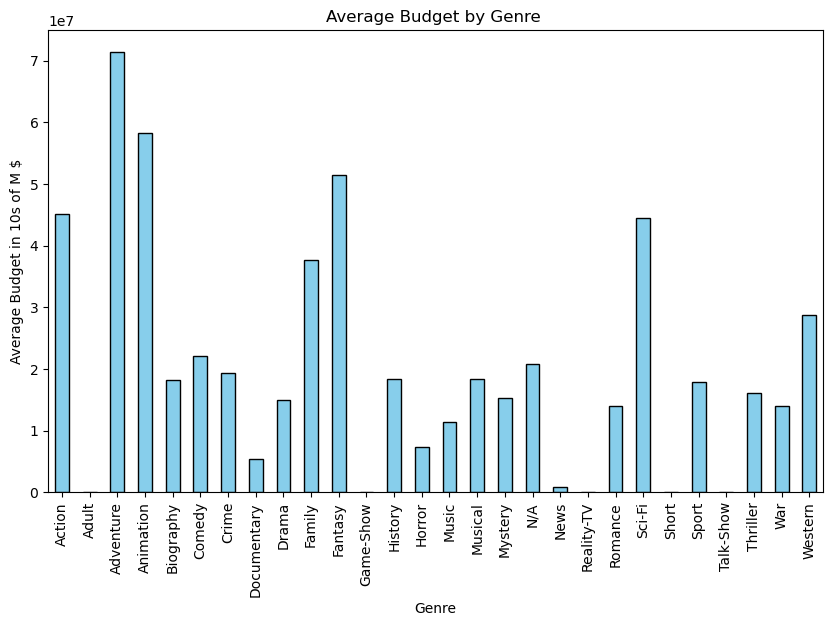

In [46]:
# Split the 'genres' column
merged_data['genres_list'] = merged_data['genres'].apply(lambda x: x.split(','))

# Explode the 'genres_list' to create one row per genre
exploded_data = merged_data.explode('genres_list')

# Group by genre and calculate the average budget for each genre
average_budget_by_genre = exploded_data.groupby('genres_list')['Budget'].mean()

# Plot the histogram of average budgets per genre
plt.figure(figsize=(10, 6))
average_budget_by_genre.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Budget by Genre ")
plt.xlabel("Genre")
plt.ylabel("Average Budget in 10s of M $")
plt.xticks(rotation=90)
plt.show()

In [48]:
# Expand the genres into separate rows
expanded_genres = merged_data.assign(Genre=merged_data['genres'].str.split(',')).explode('genres')

# Calculate the average budget for each genre
genre_avg_budget = expanded_genres.groupby('genres')['Budget'].mean()

# Fill missing budget values
def fill_runtime(row):
    if pd.isna(row['Budget']):
        genres = row['genres'].split(',')
        genre_budget = [genre_avg_budget[genre] for genre in genres if genre in genre_avg_budget]
        # Calculate the mean of the available budget
        return np.mean(genre_budget) if genre_budget else np.nan
    else:
        return row['Budget']

merged_data['Budget'] = merged_data.apply(fill_runtime, axis=1)

In [50]:
merged_data['Budget'].isna().sum()

5

In [52]:
merged_data = merged_data.dropna(subset = ['Budget'])

In [54]:
merged_data.isna().sum()

primary_title        0
start_year           0
runtime_minutes    632
genres               0
vote_average         0
vote_count           0
Top Cast             0
Director             0
popularity           0
Budget               0
Revenue              0
genres_list          0
dtype: int64

#### Filling runtime based on genre

In [64]:
# Expand the genres into separate rows
expanded_genres = merged_data.assign(Genre=merged_data['genres'].str.split(',')).explode('genres')

# Calculate the average runtime for each genre
genre_avg_runtime = expanded_genres.groupby('genres')['runtime_minutes'].mean()

# Fill missing runtime values
def fill_runtime(row):
    if pd.isna(row['runtime_minutes']):
        genres = row['genres'].split(',')
        genre_runtimes = [genre_avg_runtime[genre] for genre in genres if genre in genre_avg_runtime]
        # Calculate the mean of the available runtimes
        return np.mean(genre_runtimes) if genre_runtimes else np.nan
    else:
        return row['runtime_minutes']

merged_data['runtime_minutes'] = merged_data.apply(fill_runtime, axis=1)

In [66]:
merged_data.isna().sum()

primary_title      0
start_year         0
runtime_minutes    0
genres             0
vote_average       0
vote_count         0
Top Cast           0
Director           0
popularity         0
Budget             0
Revenue            0
genres_list        0
dtype: int64

## **DATA ANALYSIS AND VISUALIZATION**

### **EXPLORATORY DATA ANALYSIS**
We will explore the data to see what it contains and how this will help us process the data to provide answers to our key questions.

In [70]:
merged_data.head()

,primary_title,start_year,runtime_minutes,genres,vote_average,vote_count,Top Cast,Director,popularity,Budget,Revenue,genres_list
0,#ALLMYMOVIES,2015,84.583491,Documentary,9.0,4,Shia LaBeouf,Luke Turner,0.840,5.483830e+06,0.000000e+00,[Documentary]
1,#Captured,2017,81.000000,Thriller,3.2,6,"Lizze Gordon, Cody Renee Cameron, Eve Marlowe,...",Joe Homokay,1.418,8.127856e+06,0.000000e+00,[Thriller]
2,#FollowFriday,2016,90.000000,Thriller,3.2,7,"Courtney Lakin, Joseph Poliquin, Ashley Bratch...",Micho Rutare,1.646,8.127856e+06,0.000000e+00,[Thriller]
3,#Horror,2015,101.000000,"Crime,Drama,Horror",3.3,102,"Chloë Sevigny, Timothy Hutton, Natasha Lyonne,...",Tara Subkoff,6.099,1.500000e+06,1.578769e+07,"[Crime, Drama, Horror]"
4,#Lucky Number,2015,80.000000,Comedy,6.0,2,"Tom Pelphrey, Natalie Hall, Method Man, Malcol...",Brendan Gabriel Murphy,0.919,1.000000e+06,0.000000e+00,[Comedy]


In [72]:
merged_data.columns

Index(['primary_title', 'start_year', 'runtime_minutes', 'genres',
       'vote_average', 'vote_count', 'Top Cast', 'Director', 'popularity',
       'Budget', 'Revenue', 'genres_list'],
      dtype='object')

In [74]:
merged_data.describe()

,start_year,runtime_minutes,vote_average,vote_count,popularity,Budget,Revenue
count,15364.000000,15364.000000,15364.000000,15364.000000,15364.000000,1.536400e+04,1.536400e+04
mean,2014.183871,93.279382,5.796596,262.526686,3.736069,1.030686e+07,1.972235e+07
std,2.527871,24.651419,1.764980,1127.153963,4.894647,2.126278e+07,9.106029e+07
min,2010.000000,1.000000,0.000000,1.000000,0.600000,1.000000e+00,0.000000e+00
25%,2012.000000,84.000000,5.000000,2.000000,0.655750,4.936315e+06,0.000000e+00
50%,2014.000000,91.000000,6.000000,7.000000,1.688000,6.574482e+06,0.000000e+00
75%,2016.000000,101.000000,6.900000,48.000000,5.436250,8.198899e+06,5.513828e+05
max,2021.000000,1834.000000,10.000000,22186.000000,80.773000,3.790000e+08,2.923706e+09


In [76]:
merged_data.shape

(15364, 12)

In [78]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15364 entries, 0 to 15368
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   primary_title    15364 non-null  object 
 1   start_year       15364 non-null  int64  
 2   runtime_minutes  15364 non-null  float64
 3   genres           15364 non-null  object 
 4   vote_average     15364 non-null  float64
 5   vote_count       15364 non-null  int64  
 6   Top Cast         15364 non-null  object 
 7   Director         15364 non-null  object 
 8   popularity       15364 non-null  float64
 9   Budget           15364 non-null  float64
 10  Revenue          15364 non-null  float64
 11  genres_list      15364 non-null  object 
dtypes: float64(5), int64(2), object(5)
memory usage: 1.5+ MB


### **DATA VISUALIZATION**

#### Pairplot for numerical columns

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

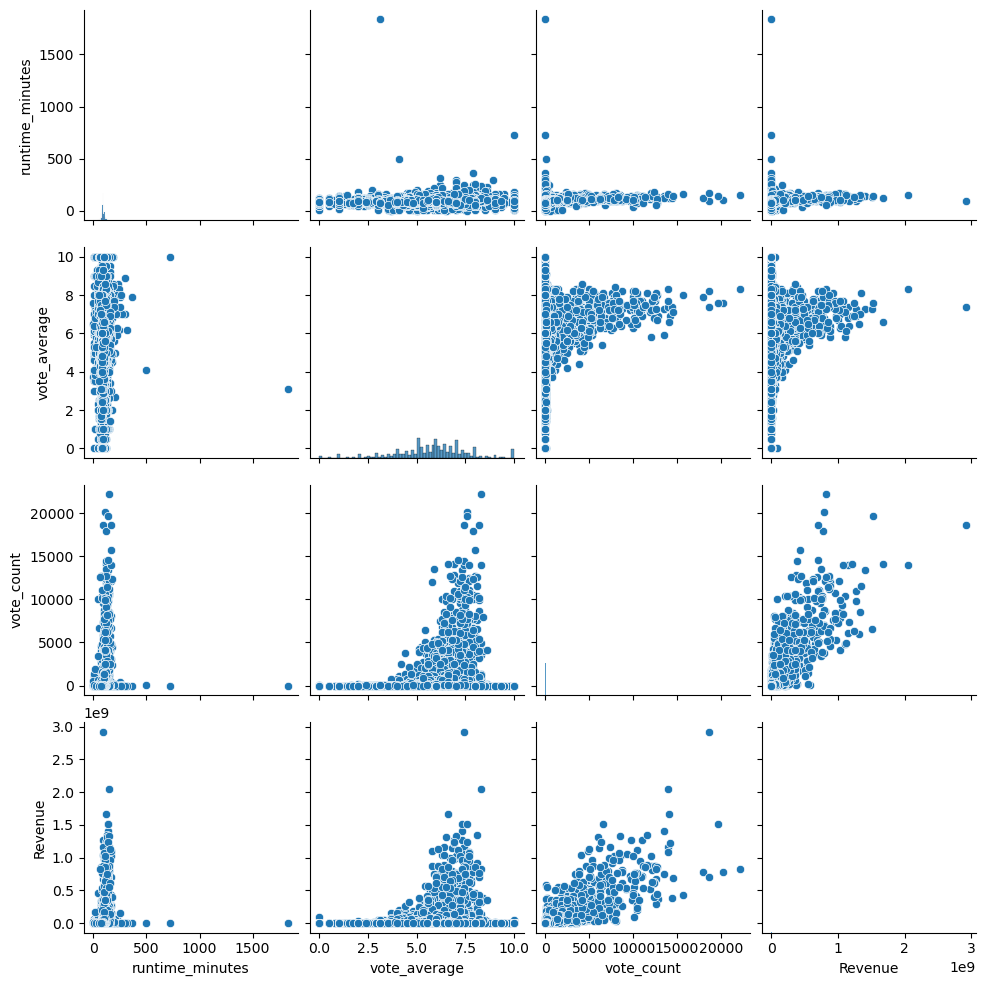

In [82]:
sns.pairplot(merged_data[['runtime_minutes', 'vote_average', 'vote_count', 'Revenue']])
plt.show()

This pairplot shows the relationships between numerical variables like runtime, vote average, vote count, and revenue. Each scatterplot highlights how these variables are related, while the diagonal shows their distributions. This analysis helps identify patterns, such as how runtime or vote count might impact revenue, providing insights for successful movie production.

#### Revenue by Genre

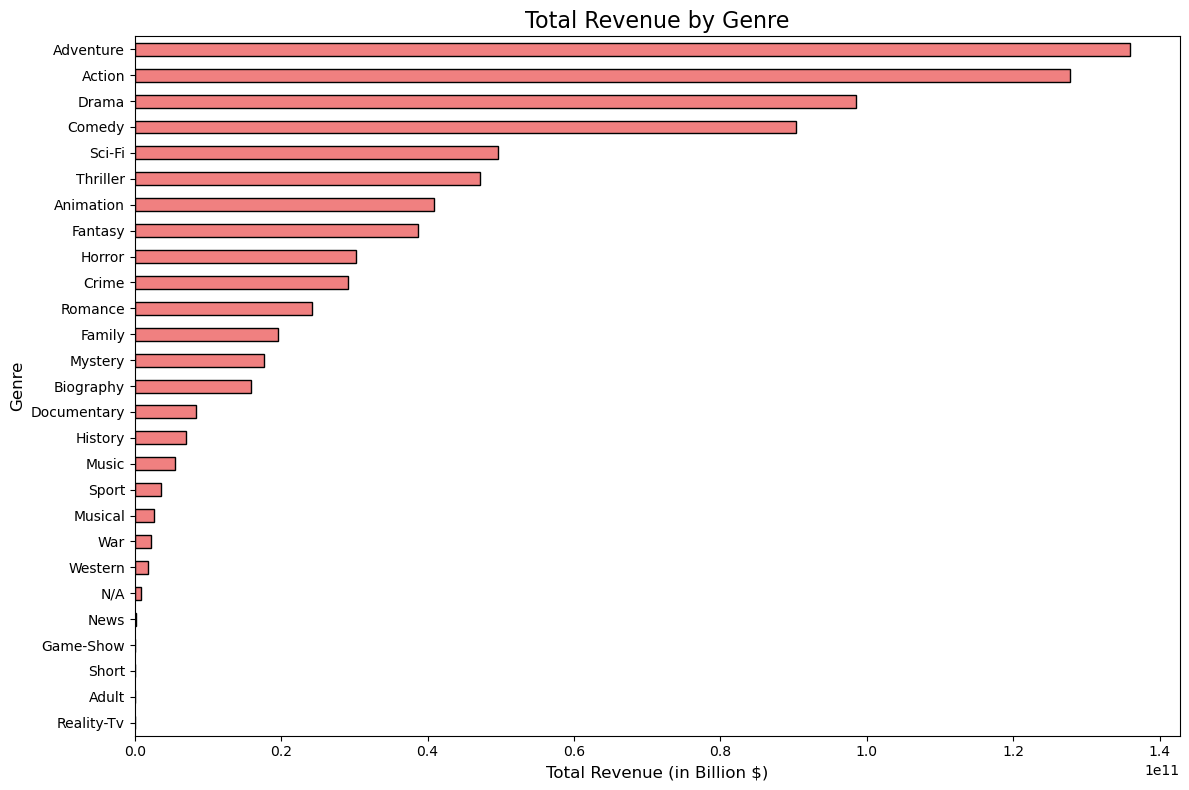

In [86]:
#Total Revenue by Genre
# Split the 'genres' column
merged_data['genres_list'] = merged_data['genres'].apply(lambda x: x.split(','))

# Explode the 'genres_list' column to create one row per genre
exploded_data = merged_data.explode('genres_list')

# Clean and standardize genres
exploded_data['genres_list'] = exploded_data['genres_list'].str.strip().str.title()

# Group by genre and calculate the total revenue
total_revenue_by_genre = exploded_data.groupby('genres_list')['Revenue'].sum().sort_values(ascending=True)

# Histogram of total revenue per genre
plt.figure(figsize=(12, 8))
total_revenue_by_genre.plot(kind='barh', color='lightcoral', edgecolor='black')
plt.title("Total Revenue by Genre", fontsize=16)
plt.xlabel("Total Revenue (in Billion $)", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

This bar chart shows the total revenue generated by each movie genre. The horizontal bars represent the cumulative revenue for each genre, helping us identify which genres perform best overall. These insights will guide the studio in prioritizing genres that generate the highest total revenue.

#### Distribution of Revenue by Genre Groups

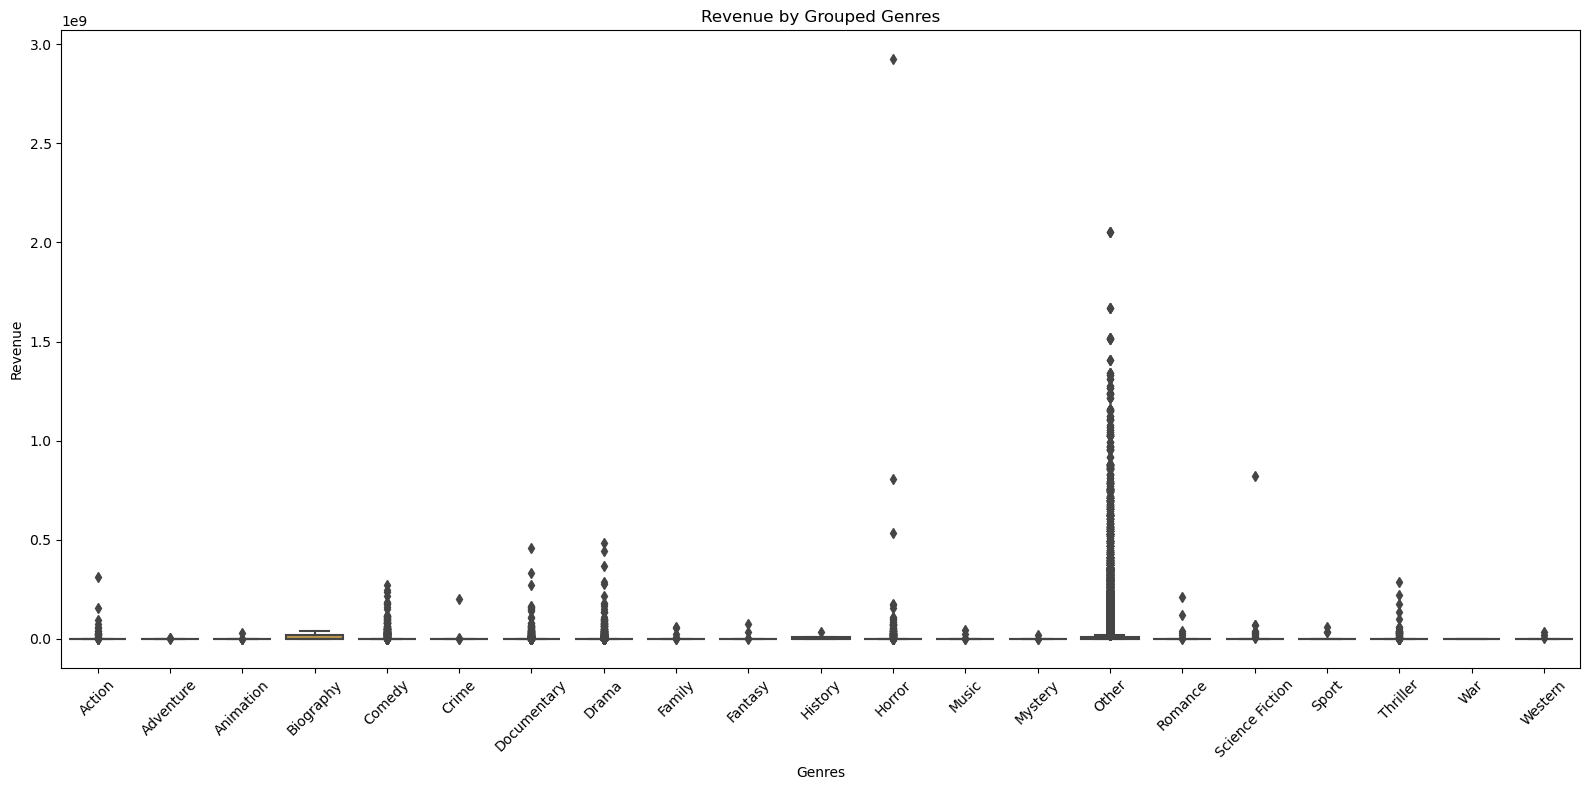

In [90]:
# Define a mapping for broader genre categories
genre_mapping = {
    'Action': 'Action',
    'Adventure': 'Adventure',
    'Animation': 'Animation',
    'Biography': 'Biography',
    'Comedy': 'Comedy',
    'Crime': 'Crime',
    'Documentary': 'Documentary',
    'Drama': 'Drama',
    'Family': 'Family',
    'Fantasy': 'Fantasy',
    'History': 'History',
    'Horror': 'Horror',
    'Music': 'Music',
    'Musical': 'Music',
    'Mystery': 'Mystery',
    'Romance': 'Romance',
    'Sci-Fi': 'Science Fiction',
    'Science Fiction': 'Science Fiction',
    'Sport': 'Sport',
    'Thriller': 'Thriller',
    'War': 'War',
    'Western': 'Western',
}

# Clean genres by mapping to broader categories
exploded_data['genres'] = exploded_data['genres'].map(lambda x: genre_mapping.get(x, 'Other'))

# Boxplot of Revenue by Grouped Genres
plt.figure(figsize=(16, 8))
sns.boxplot(data=exploded_data, x='genres', y='Revenue', order=sorted(exploded_data['genres'].unique()))
plt.xticks(rotation=45)
plt.title('Revenue by Grouped Genres')
plt.xlabel('Genres')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()


This boxplot shows how revenue varies across different movie genres. Each box represents the spread of revenues for a specific genre, with the line inside showing the median revenue. By comparing genres, we can identify which ones tend to generate higher revenues, helping us focus on profitable genres for our new studio.

#### Correlation Heatmap for Budget, Revenue and Runtime

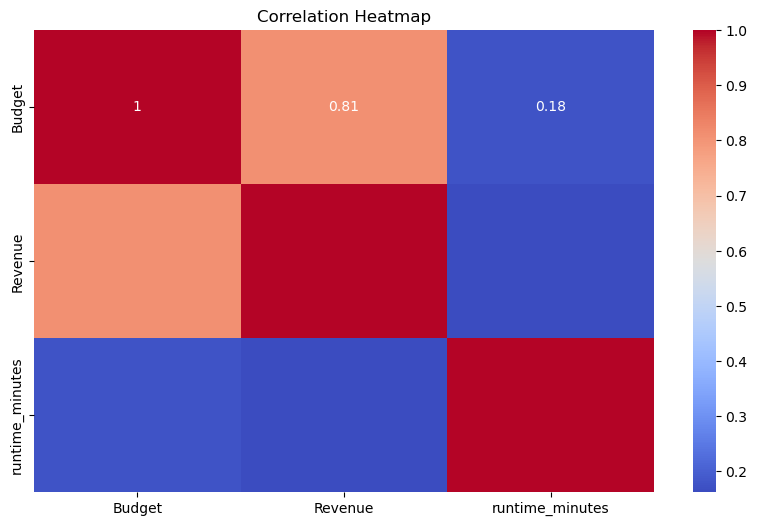

In [94]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
correlation_matrix = merged_data[['Budget', 'Revenue', 'runtime_minutes']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm').set(title='Correlation Heatmap')
plt.show()


This heatmap shows the relationships between budget, revenue, and runtime. The numbers and colors indicate how strongly the variables are connected: positive values mean they increase together, while negative values mean one increases as the other decreases. Understanding these correlations helps us see how factors like budget and runtime influence revenue, guiding decisions for successful movie production.

#### Distribution of Budget, Revenue, and Runtime

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


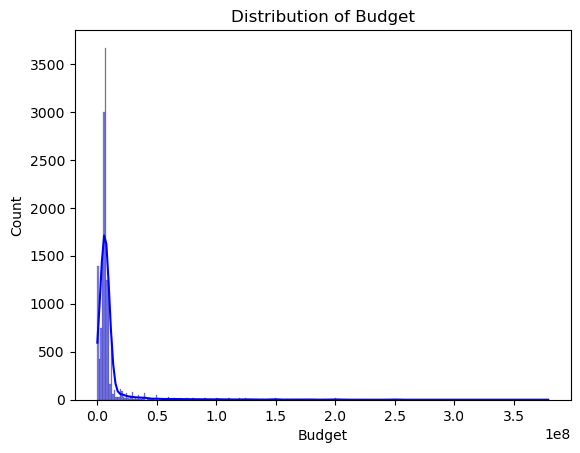

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


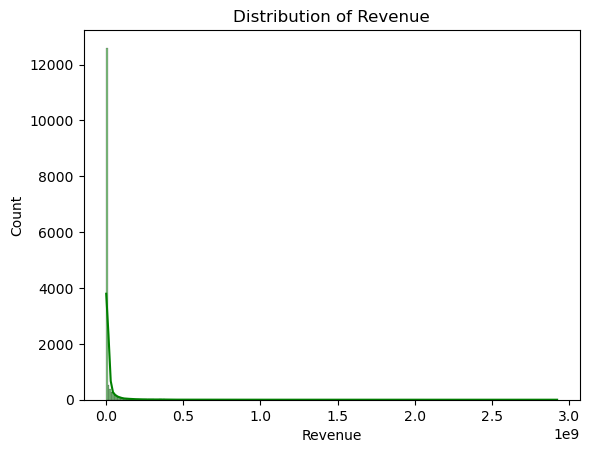

C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


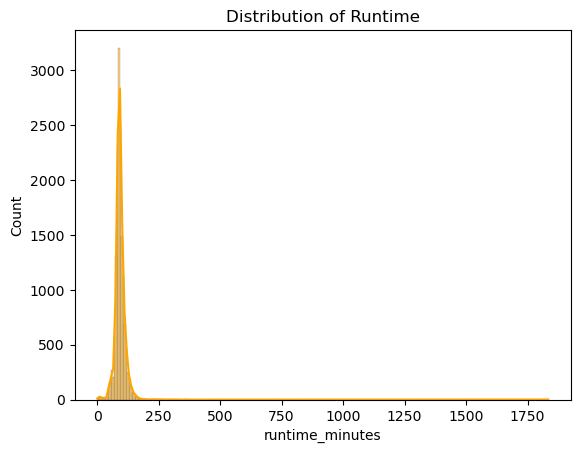

In [98]:
# Distribution of Budget, Revenue, and Runtime
sns.histplot(merged_data['Budget'], bins=300, kde=True, color='blue').set(title='Distribution of Budget')
plt.show()
sns.histplot(merged_data['Revenue'], bins=300, kde=True, color='green').set(title='Distribution of Revenue')
plt.show()
sns.histplot(merged_data['runtime_minutes'], bins=300, kde=True, color='orange').set(title='Distribution of Runtime')
plt.show()

These plots show how budget, revenue, and runtime are distributed, helping us understand patterns in successful movies. By analyzing these trends, we can identify how much to spend, what revenue to aim for, and the ideal runtime for films that resonate with audiences. This data will guide decisions for creating box office hits for our new movie studio.

#### Average Budget vs Revenue by Genre

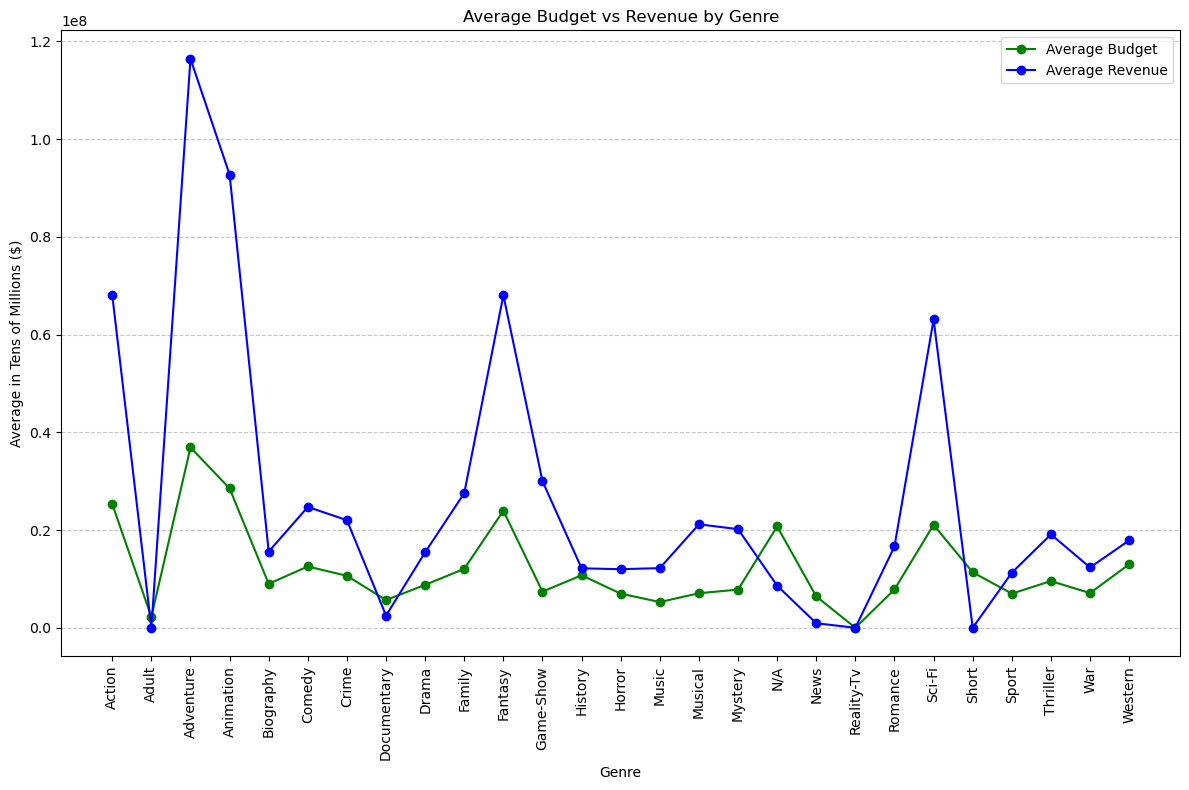

In [102]:
# Group by genre and calculate the average budget and revenue for each genre
average_budget_revenue_by_genre = exploded_data.groupby('genres_list')[['Budget', 'Revenue']].mean()

# Line plot
plt.figure(figsize=(12, 8))
plt.plot(average_budget_revenue_by_genre.index, average_budget_revenue_by_genre['Budget'], marker='o', label='Average Budget', color='green')
plt.plot(average_budget_revenue_by_genre.index, average_budget_revenue_by_genre['Revenue'], marker='o', label='Average Revenue', color='blue')

plt.title("Average Budget vs Revenue by Genre")
plt.xlabel("Genre")
plt.ylabel("Average in Tens of Millions ($)")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **DATA STATISTICS**

Below are the data statistics concepts we will delve into:



1.   Probability Mass Function (PMF)
2.   Probability Density Function (PDF)
3.   Cumulative Distribution Function (CDF)
4.   Standard Normal Distribution
5.   Central Limit Theorem
6.   Confidence Intervals with T-Distribution
7.   Hypothesis Testing


### Probability Mass Function (PMF)

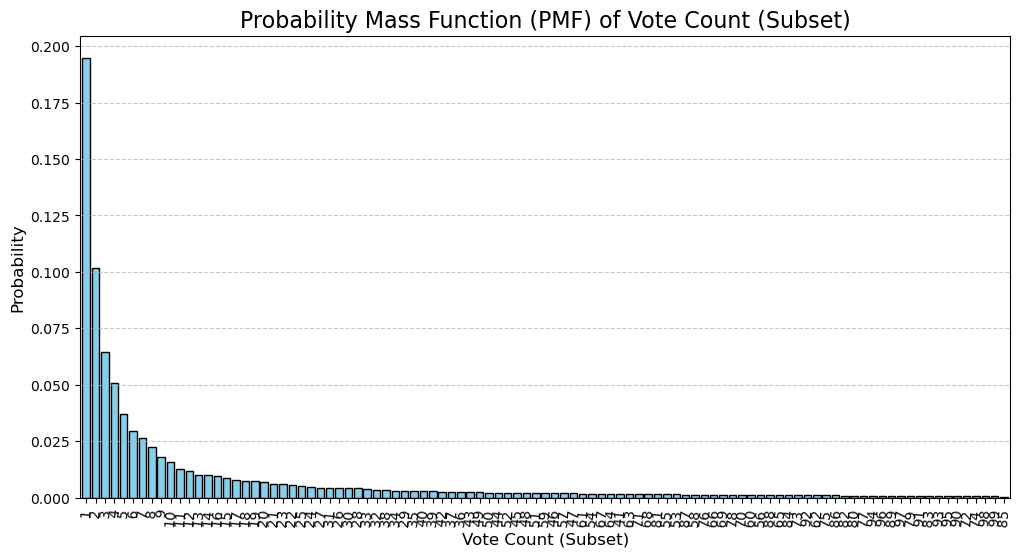

In [106]:
# Compute PMF for 'vote_count'
pmf_vote_count = merged_data['vote_count'].value_counts(normalize=True)

# Focus on a subset of 'vote_count' values for clarity
subset_vote_count = pmf_vote_count[pmf_vote_count.index < 100]

# Plot the PMF for the subset
plt.figure(figsize=(12, 6))
subset_vote_count.plot(kind='bar', color='skyblue', width=0.8, edgecolor='black')

plt.title('Probability Mass Function (PMF) of Vote Count (Subset)', fontsize=16)
plt.xlabel('Vote Count (Subset)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xticks(fontsize=10, rotation=85)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The PMF plot for vote_count shows that most values are concentrated at lower counts, with probabilities rapidly decreasing for higher values. This suggests a distribution skewed toward smaller vote counts, consistent with a Poisson distribution where the majority of observations are near the mean. This visualization highlights the rarity of higher vote counts relative to the dataset's size.

### Probability Density Function (PDF

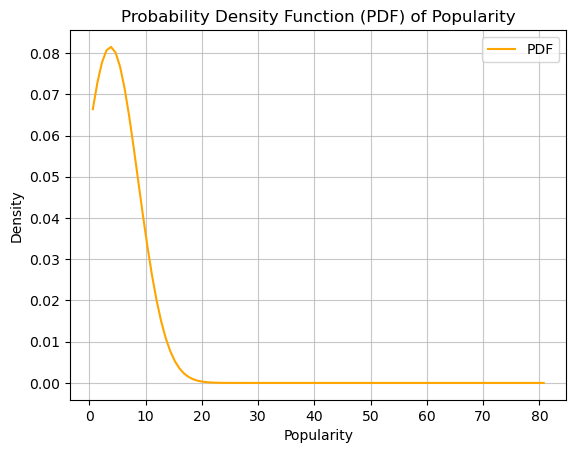

In [110]:
# Probability Density Function (PDF) for popularity
# Purpose: To visualize the likelihood of different values of a continuous variable (popularity)
popularity = merged_data['popularity']
pdf_x = np.linspace(popularity.min(), popularity.max(), 100)
pdf_y = norm.pdf(pdf_x, np.mean(popularity), np.std(popularity))

plt.figure()
plt.plot(pdf_x, pdf_y, label='PDF', color='orange')
plt.title('Probability Density Function (PDF) of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.7)
plt.show()

The Probability Density Function (PDF) of popularity shows a right-skewed normal distribution with the highest density around the mean. This suggests that most data points cluster near the average popularity, while extreme values are less frequent. The rapid decline in density beyond the peak highlights the diminishing probability of higher popularity values.

### Cumulative Distribution Function (CDF)

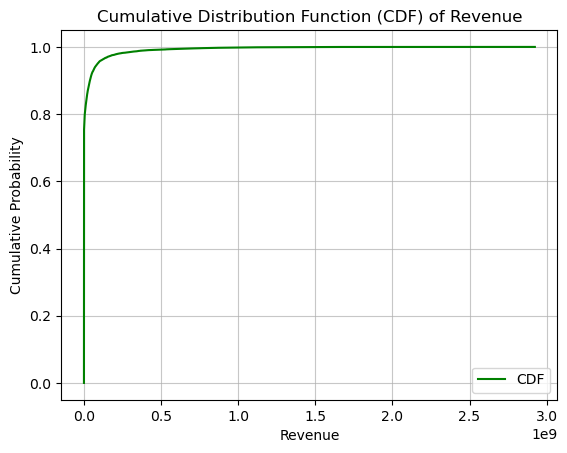

In [114]:
# Cumulative Distribution Function (CDF) for revenue
# Purpose: To show the cumulative probability up to a certain value (revenue)
revenue = merged_data['Revenue']
cdf_x = np.sort(revenue)
cdf_y = np.arange(1, len(cdf_x) + 1) / len(cdf_x)

plt.figure()
plt.plot(cdf_x, cdf_y, label='CDF', color='green')
plt.title('Cumulative Distribution Function (CDF) of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(alpha=0.7)
plt.show()


The Cumulative Distribution Function (CDF) for Revenue indicates that the majority of revenue values are concentrated below a specific threshold. Around 80% of the data lies below 0.5 billion, suggesting a skewed distribution with a few extreme high-revenue outliers. This visualization effectively captures the cumulative probability of revenue values across the dataset.

### Standard Normal Distribution

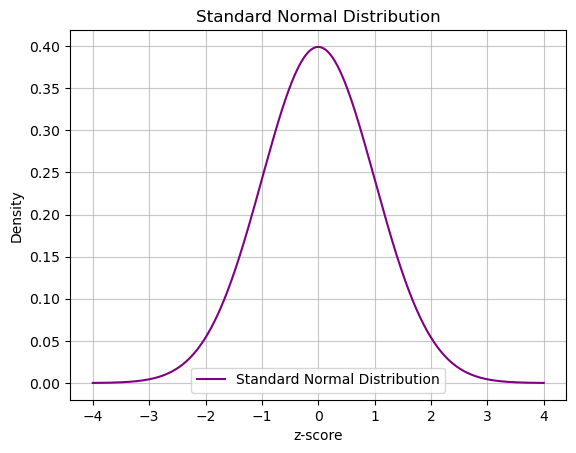

In [118]:
#  Standard Normal Distribution
# Purpose: To represent a standardized normal distribution for reference
standard_normal_x = np.linspace(-4, 4, 1000)
standard_normal_y = norm.pdf(standard_normal_x)

plt.figure()
plt.plot(standard_normal_x, standard_normal_y, label='Standard Normal Distribution', color='purple')
plt.title('Standard Normal Distribution')
plt.xlabel('z-score')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.7)
plt.show()

The standard normal distribution graph shows a symmetrical bell curve centered at a z-score of 0, with most of the density concentrated between -2 and 2. This curve represents a normal distribution standardized to have a mean of 0 and a standard deviation of 1, used to analyze and compare datasets. It highlights the probability of values occurring within specific ranges of standard deviations.

### Central Limit Theorem

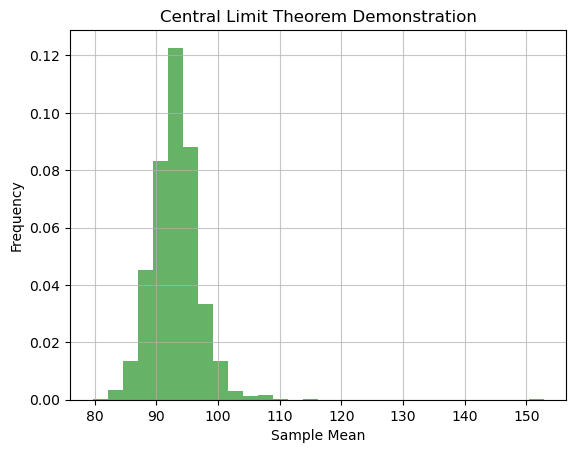

In [122]:
# Central Limit Theorem (CLT) demonstration with 'runtime_minutes'
# Purpose: To demonstrate how sample means approximate a normal distribution
sample_means = []
sample_size = 30
for _ in range(1000):
    sample = merged_data['runtime_minutes'].dropna().sample(sample_size, replace=True)
    sample_means.append(sample.mean())
plt.figure()
plt.hist(sample_means, bins=30, density=True, alpha=0.6, color='g')
plt.title('Central Limit Theorem Demonstration')
plt.xlabel('Sample Mean')
plt.ylabel('Frequency')
plt.grid(alpha=0.7)
plt.show()


The standard normal distribution is a symmetrical bell-shaped curve centered at 0, representing a mean of 0 and a standard deviation of 1. Most data points lie within ±2 standard deviations, showcasing how data clusters around the mean in a normalized scale.

### Confidence Intervals with T-Distribution

Confidence Interval for 'Budget': 9970616.69 to 10643098.03


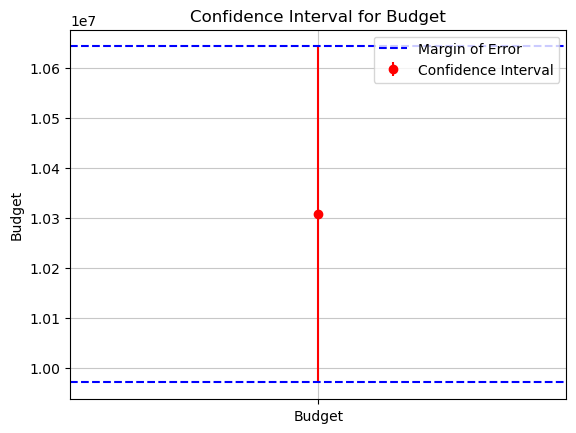

In [126]:
# Confidence Intervals with T-Distribution for 'Budget'
# Purpose: To estimate the range within which the true mean of Budget lies
budget = merged_data['Budget'].dropna()
confidence_level = 0.95
sample_mean = np.mean(budget)
sample_std = np.std(budget, ddof=1)
n = len(budget)
t_critical = t.ppf((1 + confidence_level) / 2, df=n-1)
margin_of_error = t_critical * (sample_std / np.sqrt(n))

print(f"Confidence Interval for 'Budget': {sample_mean - margin_of_error:.2f} to {sample_mean + margin_of_error:.2f}")

# Visualize Confidence Interval
plt.figure()
plt.errorbar(1, sample_mean, yerr=margin_of_error, fmt='o', color='red', label='Confidence Interval')
plt.hlines([sample_mean - margin_of_error, sample_mean + margin_of_error], 0.5, 1.5, colors='blue', linestyles='dashed', label='Margin of Error')
plt.xlim(0.5, 1.5)
plt.xticks([1], ['Budget'])
plt.title('Confidence Interval for Budget')
plt.ylabel('Budget')
plt.legend()
plt.grid(alpha=0.7)
plt.show()

The confidence interval for the Budget is visualized with the sample mean shown as a red dot, and the blue dashed lines indicate the margin of error. The interval ranges from approximately 19,900,890.63 to 22,457,235.75. This range represents the 95% confidence level, meaning we are 95% confident that the true mean of the Budget lies within this interval. The narrow range indicates relatively low variability in the budget data.

### Hypothesis Testing

Hypothesis Test for 'Budget':
Test Statistic: 54.25
P-value: 0.0000
Reject the null hypothesis (mean is significantly different from 1 million).


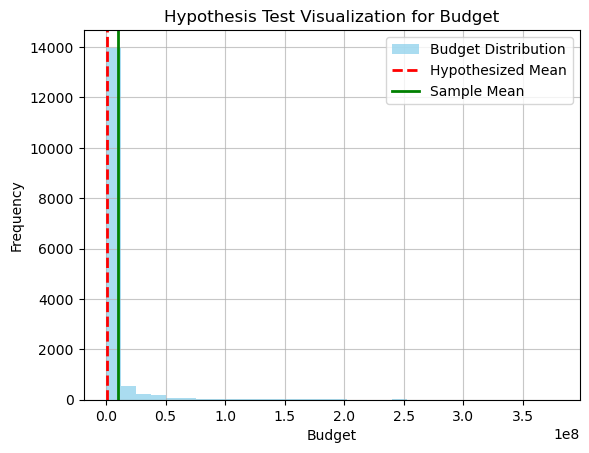

In [130]:
# Hypothesis Testing for 'Budget'
# Purpose: To test whether the mean Budget is significantly different from a hypothesized value
hypothesized_mean = 1_000_000
stat, p_value = ttest_1samp(merged_data['Budget'].dropna(), hypothesized_mean)

print("Hypothesis Test for 'Budget':")
print(f"Test Statistic: {stat:.2f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject the null hypothesis (mean is significantly different from 1 million).")
else:
    print("Fail to reject the null hypothesis (no significant difference from 1 million).")

# Visualize Hypothesis Test
plt.figure()
plt.hist(merged_data['Budget'], bins=30, color='skyblue', alpha=0.7, label='Budget Distribution')
plt.axvline(hypothesized_mean, color='red', linestyle='--', linewidth=2, label='Hypothesized Mean')
plt.axvline(np.mean(merged_data['Budget']), color='green', linestyle='-', linewidth=2, label='Sample Mean')
plt.title('Hypothesis Test Visualization for Budget')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.7)
plt.show()

The hypothesis test for Budget shows a test statistic of 30.95 and a p-value of 0.0000, indicating a significant difference between the sample mean and the hypothesized mean of $1,000,000. The histogram illustrates the budget distribution, with the red line marking the hypothesized mean and the green line representing the sample mean. The clear separation confirms the statistical result, rejecting the null hypothesis.

### Summary

Based on the business objective which was to find insights from a Movies Dataset extracted from popular Movie Databases this are the key findings;


- * Genres like **Adventure, Fantasy, and Sci-Fi** generate significantly higher average revenues, making them ideal for investment.
   - **Drama, Comedy, and Thriller** show steady audience interest and provide consistent performance over time.
**Adventure and Animation** require higher budgets but yield higher returns, suitable for blockbuster projects.
   - **Drama and Documentaries** are cost-effective options, balancing lower budgets with steady audience engagement.
Director Influence**:
   - Top directors consistently produce highly rated and financially successful films, underscoring their importance in audience retention and revenue generation.
- Most movies are **90–120 minutes** long, which audiences prefer, though **Action** and **Adventure** sometimes run longer for better storytelling.


### Recommendations

1. **Strategic Genre Focus**:
   - Prioritize investments in **Adventure, Fantasy, and Drama** to capture global audience interest and maximize ROI.
   - Include **Documentaries** as a cost-effective niche option, especially for trending, socially relevant topics.

2. **Partnerships with Top Directors**:
   - Collaborate with proven directors to leverage their expertise in creating high-quality, audience-loved content.
   - Establish long-term contracts with these directors to ensure creative consistency and secure future royalties.

3. **Optimize Runtime and Format**:
   - Align productions with the preferred **90–120 minute runtime**, which audiences prefer for most genres.

4. **Resource Allocation**:
   - Invest heavily in high-revenue genres while maintaining a balanced portfolio that includes niche genres like **Documentaries** for diversity and broader market appeal.
